In [2]:
from psycopg2 import connect
from modules.Acesso import Acesso
from modules.conector_postgree import Interface_db_postgree
from modules.conector_cassandra import Interface_db_cassandra
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import psycopg2
from psycopg2.extras import execute_values
from cassandra.query import BatchStatement
from cassandra.cluster import Cluster, ProfileManager
import matplotlib.pyplot as plt

In [12]:
def chunk(dataframe, size):
    
    for i in range(0, len(dataframe), size): 
        yield dataframe[i:i + size]

In [13]:
lendo = Acesso(r"C:\Users\isa66\Desktop\Visualcode\.vscode\Telecomunicações\arquivos\Municipios_acesso_cobertura\Meu_Municipio_Acessos.csv")
lendo.tratamento_geral()
df_municipio_acessos = lendo.get_resultado()
print('tratado')

tratado


In [14]:
chunked_municipio_acessos = chunk(df_municipio_acessos, 50000)

In [15]:
con = psycopg2.connect(user='postgres', password='Eugostode@55', host='localhost', database='telecomunicacao')
cursor = con.cursor()
print('conexao')

conexao


In [16]:
for df in chunked_municipio_acessos:
    try:
        data = np.array(df)
        list_postgre = []
        for item in data:
            value = tuple(item)
            list_postgre.append(value)  
        # list_postgre = str(list_postgre)[1:-1]
        sql = f"INSERT INTO municipio_acesso (ano ,mes , Acesso, Servico, Densidade, codigo_ibge, municipio, uf, nome_uf, regiao, codigo_nacional) values  %s;"
        execute_values(cursor, sql, list_postgre)
        con.commit()
        print('inerindo')
    except Exception as e:
        print("Erro ao inserir dados ", str(e))

inerindo
inerindo


In [52]:
conect_post = Interface_db_postgree('postgres','Eugostode@55', 'localhost', 'telecomunicacao')

In [53]:
dados_municipio_acesso = conect_post.select(query="select t1.*, t2.Densidade,  t2.codigo_ibge, t2.municipio, t2.uf, t2.nome_uf, t2.regiao, t2.codigo_nacional from Servicos t1  inner join LocaisAcesso t2 on t1.id_acessos = t2.id_acessos order by t1.id_acessos;") 
df_municipio_acesso = pd.DataFrame(dados_municipio_acesso)
a = df_municipio_acesso.info()
# a[6] = a[6].astype(str, errors = 'raise')
print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66837 entries, 0 to 66836
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       66837 non-null  int64 
 1   1       66837 non-null  int64 
 2   2       66837 non-null  int64 
 3   3       66837 non-null  object
 4   4       66837 non-null  object
 5   5       66837 non-null  object
 6   6       66837 non-null  object
 7   7       66837 non-null  object
 8   8       66837 non-null  object
 9   9       66837 non-null  object
 10  10      66837 non-null  object
 11  11      66837 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 6.1+ MB
None


In [55]:
query = """
    INSERT INTO municipio_acesso (
        id_acessos,
        ano ,
        mes ,
        Acesso ,
        Servico ,
        Densidade ,
        codigo_ibge ,
        municipio ,
        uf ,
        nome_uf ,
        regiao ,
        codigo_nacional 
    ) values (
        ?,?,?,?,?,?,?,?,?,?,?,?
    )
"""

In [56]:
conect_cassa = Interface_db_cassandra('telecomunicacoes') 

In [57]:
insert = conect_cassa.connector().prepare(query)
chunked_df = chunk(df_municipio_acesso, 100)
for df in chunked_df:
    batch = BatchStatement()
    for _, row in df.iterrows():
        batch.add(insert, tuple(row))
    print(">> executando batch")
    conect_cassa.inserir(batch)
print(">> dados inseridos")
    
print("inseriu tudo")

>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch
>> executando batch


In [3]:
conect_cassa = Cluster()
session = conect_cassa.connect("telecomunicacoes")

In [4]:
query = "SELECT * FROM municipio_acesso;"
a = session.execute(query) 

In [5]:
lista = []
for i in a:
    lista.append(i)
b = pd.DataFrame(lista)   
print(b)

       id_acessos acesso   ano codigo_ibge  codigo_nacional        densidade  \
0            4317  27016  2021     2607752               81  94,970260223048   
1           62693    987  2019     2607703               87  22,472677595628   
2           51678   1728  2019     3108107               31  25,160163075131   
3           35262  27054  2020     4201307               47  67,933407549843   
4           54191     46  2019     3145059               38             1,84   
...           ...    ...   ...         ...              ...              ...   
66832       55834   3572  2019     4200309               47  65,565345080764   
66833       40920    253  2020     2209005               89  12,981015905593   
66834       11033    823  2021     1304237               97  16,552695092518   
66835       28249    216  2020     3165602               32  32,383808095952   
66836       56818   6823  2019     3111408               34  83,400809716599   

       mes                 municipio   

In [7]:
b.sort_values(by=['id_acessos'], ascending=False, inplace=True)
b['acesso'] = b['acesso'].astype(float, errors = 'raise')
banda_larga = b.loc[b["servico"] == 'Banda Larga Fixa']
telefonia_fixa = b.loc[b["servico"] == 'Telefonia Fixa']
telefonia_movel = b.loc[b["servico"] == 'Telefonia Móvel']
tv_por_assinatura = b.loc[b["servico"] == 'Tv por Assinatura'] 


print(b.info())
dataframe_banda_larga = banda_larga.groupby("ano").mean()
dataframe_banda_larga.reset_index(inplace = True)
dataframe_telefonia_fixa = telefonia_fixa.groupby("ano").mean()
dataframe_telefonia_fixa.reset_index(inplace = True)
dataframe_telefonia_movel = telefonia_movel.groupby("ano").mean()
dataframe_telefonia_movel.reset_index(inplace = True)
dataframe_tv_por_assinatura = tv_por_assinatura.groupby("ano").mean()
dataframe_tv_por_assinatura.reset_index(inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66837 entries, 43281 to 18657
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_acessos       66837 non-null  int64  
 1   acesso           66837 non-null  float64
 2   ano              66837 non-null  int64  
 3   codigo_ibge      66837 non-null  object 
 4   codigo_nacional  66837 non-null  int64  
 5   densidade        66837 non-null  object 
 6   mes              66837 non-null  int64  
 7   municipio        66837 non-null  object 
 8   nome_uf          66837 non-null  object 
 9   regiao           66837 non-null  object 
 10  servico          66837 non-null  object 
 11  uf               66837 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 6.6+ MB
None


In [8]:
dataframe_banda_larga.head()

,ano,id_acessos,acesso,codigo_nacional,mes
0,2019,55697.00000,5907.899102,57.099641,12.0
1,2020,33417.00000,6525.075404,57.099641,12.0
2,2021,11138.59623,6667.196230,57.099641,6.0


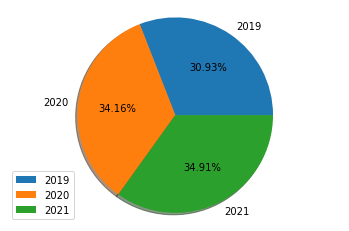

In [15]:
# dataframe_banda_larga.plot(x='ano', kind='bar', title='Banda Larga',color = 'blue')
# plt.ylim(100)
# plt.xlabel("ano", fontsize=14)
# plt.ylabel("acesso", fontsize=14)
# plt.legend(['acesso'])
# dataframe_telefonia_fixa.plot(x='ano', kind='bar', title='Telefonia Fixa',color = 'grey')
# plt.ylim(100)
# plt.xlabel("ano", fontsize=14)
# plt.ylabel("acesso", fontsize=14)
# plt.legend(['acesso'])
# dataframe_telefonia_movel.plot(x='ano', kind='bar', title='Telefonia Movel',color = 'black')
# plt.ylim(100)
# plt.xlabel("ano", fontsize=14)
# plt.ylabel("acesso", fontsize=14)
# plt.legend(['acesso'])
# dataframe_banda_larga.plot(x='ano', kind='bar', title='Tv por Assinatura', color = 'darkblue')
# plt.ylim(100)
# plt.xlabel("ano", fontsize=14)
# plt.ylabel("acesso", fontsize=14)
# plt.legend(['acesso'])
# explode = (0.1) 
plt.pie(dataframe_banda_larga['acesso'], labels=dataframe_banda_larga['ano'], autopct='%1.2f%%', shadow=True)
plt.legend(dataframe_banda_larga['ano'], loc=3)
plt.axis('equal')
plt.show()
